In [5]:
import random
def randbool():
    return random.randint(0,1)==0
def simulate():
    """
    Master/Slave Serialized Communication
    Slaves send bit to master
    Master then clears channel
    Master has to recieve 2 * n communications because channel can start "on"
    """
    
    people = [0] * 100
    switches = [randbool(), randbool()]
    turns = 0
    count = 0
    while count < 198:
        prisoner = random.randint(0,99)
        if prisoner == 0:
            if switches[0] == True:
                switches[0] = False
                count += 1
            else:
                switches[1] = not switches[1]
        else:
            if switches[0] == False and people[prisoner] < 2:
                people[prisoner] += 1
                switches[0] = True
            else:
                switches[1] = not switches[1]
        turns += 1
    return turns

In [4]:
results = [simulate() for x in range(10000)]

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

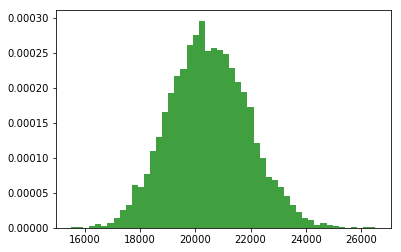

In [8]:
n, bins, patches = plt.hist(results, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

In [9]:
import numpy as np

In [10]:
np.mean(results)

20483.981899999999